# Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks

The article is available at https://arxiv.org/pdf/1703.03400.pdf.

MAML algorithm aims to deep train a network to make it able to learn a new task very fast. The idea is to have a maximal performance with a few gradient steps (one or more) and a small amount of data when we give it a new model to learn. It is agnostic, meaning that it can be applied to any learning problem as far as it is trained with a gradient descent procedure. MAML can be used for regression, classification and reinforcement learning.

A good example for illustrating MAML purpose in the article was a classification problem: the recognition of a segway image. With MAML, we'll train the network with a lot of different types of images, and then it will be able to recognize a segway after seing only a few examples. 

In this notebook, we'll study only regression case, with the example of the sine wave. If the first part, we define the parameters and data generator. Then, we will build two networks: a classic neural network and MAML, to compare their performance at the end.

For experiments developped in the article, another way of coding MAML has been implemented in python (it is more general but also more complicated to understand). It is available at github.com/cbfinn/maml and github.com/cbfinn/maml_rl for reinforcment learning.

### Imports and classes definitions

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as keras_backend


# Other dependencies
import random
import sys

import numpy as np
import matplotlib.pyplot as plt


We define the train and test data generator with the class $SinusoidGenerator$. It creates a sine function with random amplitude $ A \in [0.1, 5.0]$ and a random phase $ \omega \in [0, \pi]$. The parameters $K$ is the number of random datapoints used for training the model on this function. In the article, they used $K = 10$ for training.

The data function is $f(x) = A*\sin(x - \omega)$


In [2]:
class SinusoidGenerator():

    def __init__(self):

        # DEFINE K, amplitude and phase

        self.K =
        self.amplitude = 
        self.phase = 
    
    def f(self, x):

        # DEFINE f(x)
        f_x = 

        return f_x

    def x_y_sample(self, x = None):
        if x is None:
            x = np.random.uniform(-5, 5, self.K)
        y = self.f(x)
        return x[:, None], y[:, None]
    

SyntaxError: ignored


Let's create a training dataset made of 10 000 $SinusoidGenerator$ objects. 

In [3]:
#DEFINE train_ds

train_ds = 


Let's now create the neural network that will learn sine recognition. Input($x$) and ouput ($f(x)$) both have a dimention of $1$. The network has two hidden layers of shape $40$ and the activation function is $relu$. Those parameters were specified in the article.

In [4]:
class SineModel(keras.Model):
    def __init__(self):
        super().__init__()
        self.hidden1 = keras.layers.Dense(40, input_shape=(1,))
        self.hidden2 = keras.layers.Dense(40)
        self.out = keras.layers.Dense(1)
        
    def forward(self, x):
        x = keras.activations.relu(self.hidden1(x))
        x = keras.activations.relu(self.hidden2(x))
        x = self.out(x)
        return x


#### Classic neural network

For training the network to recognize a sine function, we use MSE as loss function, Adam as optimizer and the gradient descent as criteria for the optimizer. At each step of the training, a new $SinusoidGenerator$ sample is used. It is trained once with a sample of $K$ random datapoints.

In [5]:
def loss_function(pred_y, y):
  return keras_backend.mean(keras.losses.mean_squared_error(y, pred_y))

    
def train_sample(x, y, model, optimizer):
    tensor_x, tensor_y = tf.convert_to_tensor((x, y))
    with tf.GradientTape() as tape:
        mse = loss_function(y, model.forward(x))
    gradients= tape.gradient(mse, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return mse




In [6]:
def train_model(model, dataset, lr=0.001):
   
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    total_loss = 0
    
    for i, sine_wave in enumerate(dataset):
        
        #DEFINE x,y a random dataset of K point. Use a class method of sine_wave
        x, y = 
        
        loss = train_sample(x, y, model, optimizer)

        total_loss += loss
        curr_loss = total_loss / (i + 1.0)
        
        if i % 1000 == 0 :
            print('Step', i, ': loss =', curr_loss.numpy())

            plt.scatter(x, y, c = 'blue')

            x_test= np.arange(-5,5,step = 0.5)
            x_test = x_test.reshape(x_test.shape[0], 1)
            plt.scatter(x_test, model.forward(x_test), c='orange')

            x_linspace = np.linspace(-5,5,101)
            plt.plot(x_linspace, sine_wave.f(x_linspace), c='blue')
            plt.show() 


Now we can create a neural network and train it with the training dataset. We are supposed to get a decresasing loss and to have outputs (onge dots on the plots) closer and closer to the average $SinusoidGenerator$, with $A = 2.5$ and $\omega = \pi/2$

Step 0 : loss = 3.1931683084150966


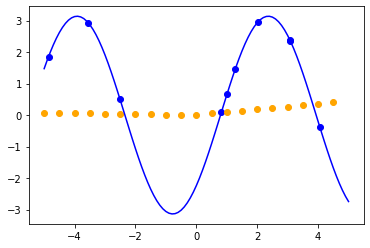

Step 1000 : loss = 3.5597686088228326


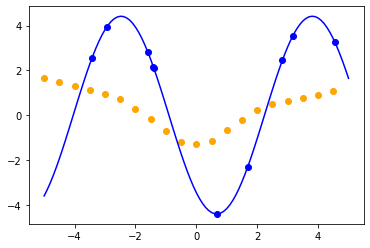

Step 2000 : loss = 3.50534734000812


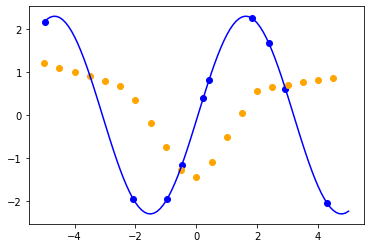

Step 3000 : loss = 3.459076528913142


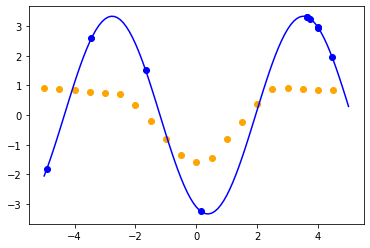

Step 4000 : loss = 3.4123313047928474


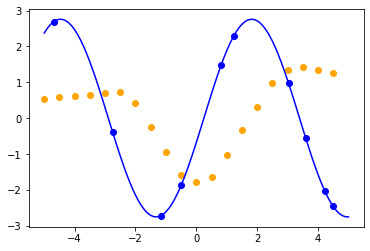

Step 5000 : loss = 3.3477484173567116


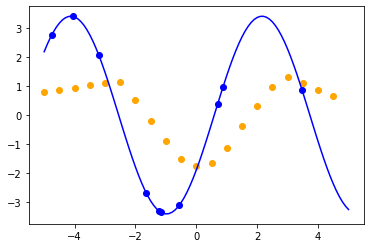

Step 6000 : loss = 3.3130615812200848


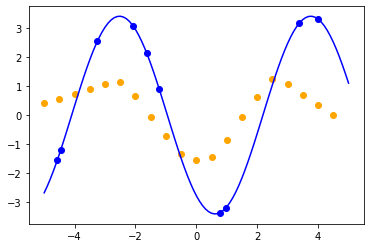

Step 7000 : loss = 3.2724337897512665


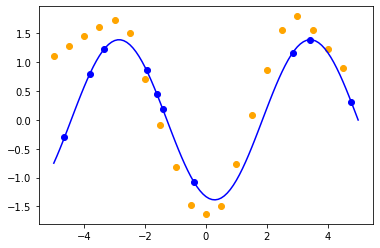

Step 8000 : loss = 3.2539646757259524


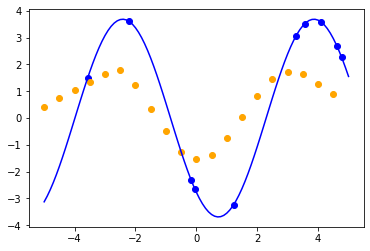

Step 9000 : loss = 3.2262076207115786


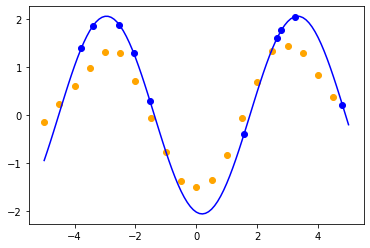

In [7]:
neural_net = SineModel()
train_model(neural_net, train_ds)

### MAML


We can define the MAML training function for a similar neural network. The loss function is still MSE but now, at each step we do not try to minimize the current MSE but a "fake" MSE defined as the MSE the model would return if we trained it with the current training data. MAML anticipates the loss when training a new tasks and the purpose is minimizing that loss.

To compute a fake task learning without modifying the model, we need to use a copy the model at each step to train a new sine function. Let's first define a function to copy the model, which build a new $SineModel$ object and then gets ans copies the model weights.

In [8]:
def copy_model(model, x):

    copied_model = SineModel()
    copied_model.forward(tf.convert_to_tensor(x))
    copied_model.set_weights(model.get_weights())
    
    return copied_model


With the MAML algorithm below, we can define the training function for MAML.



<div class="alert alert-success">

**MAML for Few-Shot Supervized Learning:**
<ol style="list-style-type:none">
<li> Input $p(T)$: distribution over tasks (here, sine wave)
<li> Input $\alpha, \beta$: step size hyperparameters (here, learning rate = 0.001)
<li> Randomly inilialize $\theta$
<li> while not done do:
    <ol style="list-style-type:none">
    <li> Sample batch of tasks $T_i \mathtt{\sim}p(T)$ (here, train_data)
    <li> for all $\tau_i$ do:
      <ol style="list-style-type:none">
      <li> Sample $K$ datapoints $D = {x^j, y^j}$ from $T_i$, 
      <li> Evaluate $\nabla_\theta L_{T_i}(f_\theta)$ using $D$ and $L_{T_i}$
      <li> Compute adapted parameters with gradient descent : $\theta_i' \leftarrow \theta - \alpha \nabla_{\theta}L_{T_i}(f_\theta)$
      <li> Sample datapoints $D_i' = {x^j, y^j}$ from $T_i$ for the meta-update
      </ol>
    <li> end for 
    <li> Update $\theta \leftarrow \theta - \beta \nabla_{\theta} \sum\limits_{T_i \mathtt{\sim} p(T)}L_{T_i}(f_{\theta_i'})$ using each $D_i'$ and $L_{T_i}$
    </ol>
<li>end while
</ol>


In [9]:
def train_maml(model, dataset, epochs=1, lr_inner=0.01, batch_size=1, log_steps=1000):

    optimizer = keras.optimizers.Adam()
 
    for epoch in range(epochs):

        total_loss = 0

        for i, sine_wave in enumerate(dataset):

            x, y = tf.convert_to_tensor(sine_wave.x_y_sample())
            model.forward(x)  


            with tf.GradientTape() as test_tape:
                
                with tf.GradientTape() as train_tape:

                    #DEFINE train_loss AS THE MSE BETWEEN y AND y_pred
                    y_pred = 
                    train_loss = 

                gradients = train_tape.gradient(train_loss, model.trainable_variables)
                k = 0

                fake_model = copy_model(model, x)
                for j in range(len(fake_model.layers)):

                    new_kernel = tf.subtract(model.layers[j].kernel, tf.multiply(lr_inner, gradients[k]))
                    new_biases = tf.subtract(model.layers[j].bias,  tf.multiply(lr_inner, gradients[k+1]))
                     
                    fake_model.layers[j].kernel = new_kernel
                    fake_model.layers[j].bias = new_biases
                    k += 2

                
                #DEFINE y_pred AND test_loss
                fake_y_pred = 
                test_loss = 

            gradients = test_tape.gradient(test_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
            total_loss += test_loss
            loss = total_loss / (i+1.0)
            
            if i % 100 == 0 and i > 0:
                print('Step {}: loss = {}'.format(i, loss))

                plt.scatter(x, y)

                truc= np.arange(-5,5,step = 0.5)
                truc = truc.reshape(truc.shape[0], 1)
                plt.scatter(truc, model.forward(truc))


                x_linspace = np.linspace(-5,5,101)
                plt.plot(x_linspace, sine_wave.f(x_linspace))
                plt.show() 
    

Let's create a new neural network with $SineModel$ and train it.

Step 100: loss = 3.844823851192959


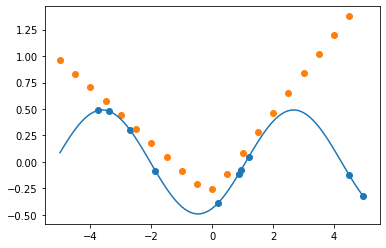

Step 200: loss = 3.341488315923102


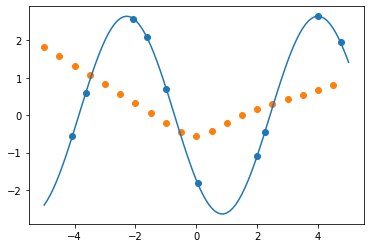

Step 300: loss = 3.0246926102920377


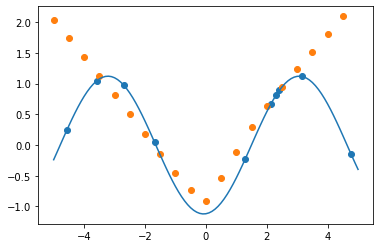

Step 400: loss = 3.054469008705677


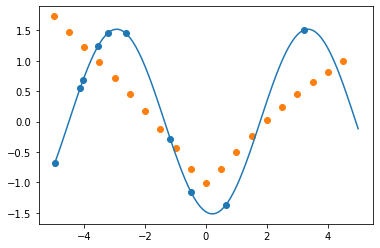

Step 500: loss = 2.900452157469769


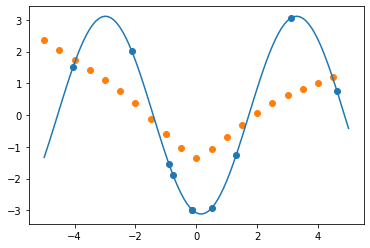

Step 600: loss = 2.820295967198754


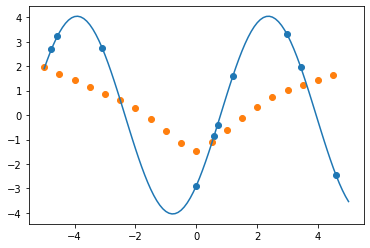

Step 700: loss = 2.7435144061989583


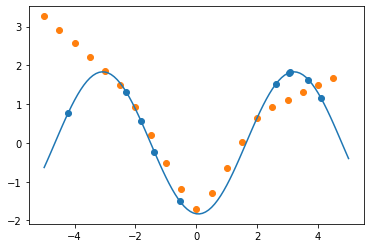

Step 800: loss = 2.6888001927659086


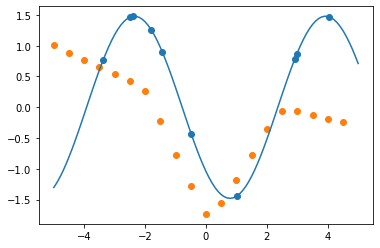

Step 900: loss = 2.617580519098735


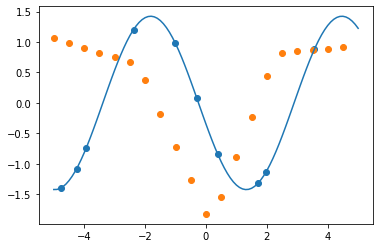

Step 1000: loss = 2.5408888539479535


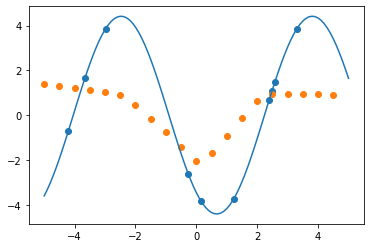

Step 1100: loss = 2.4870521301103885


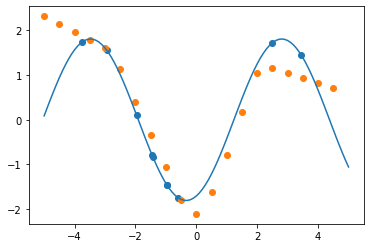

Step 1200: loss = 2.403006713701252


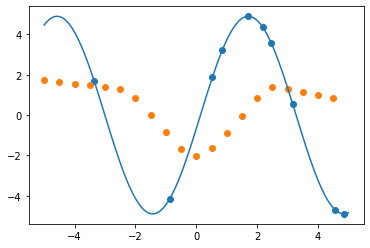

Step 1300: loss = 2.3406040417742835


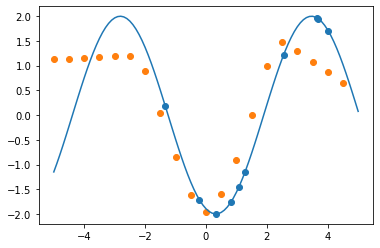

Step 1400: loss = 2.2877382243289084


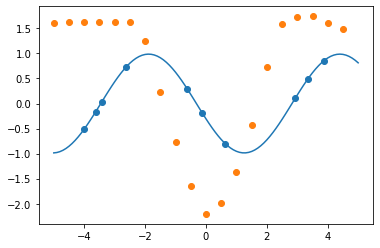

Step 1500: loss = 2.244200260273434


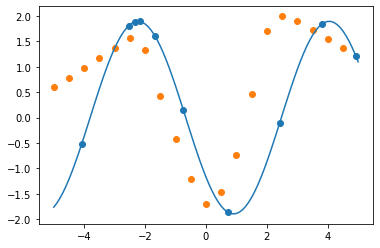

Step 1600: loss = 2.1998624742190587


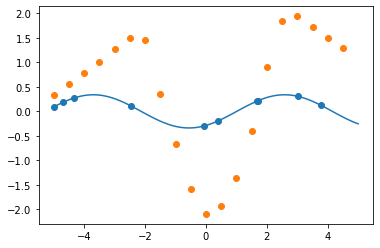

Step 1700: loss = 2.152988447539729


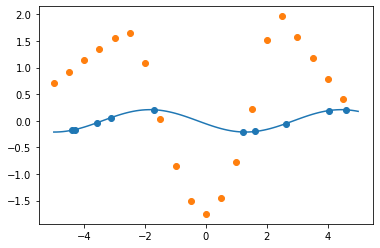

Step 1800: loss = 2.118496763790748


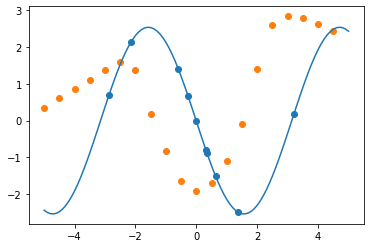

Step 1900: loss = 2.0723542047894723


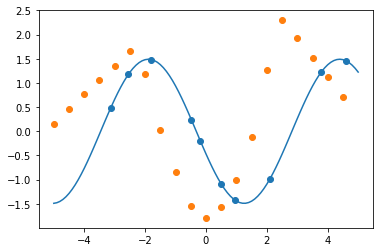

Step 2000: loss = 2.021753564961421


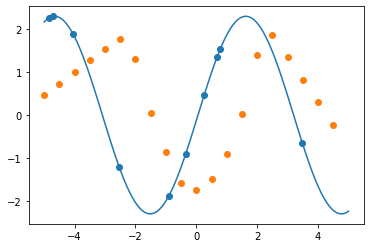

Step 2100: loss = 1.9865112091570987


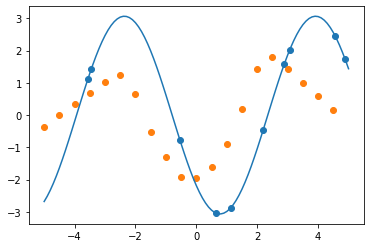

Step 2200: loss = 1.9462933917238512


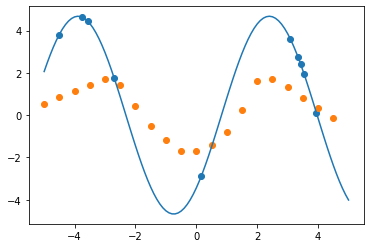

Step 2300: loss = 1.918550693635476


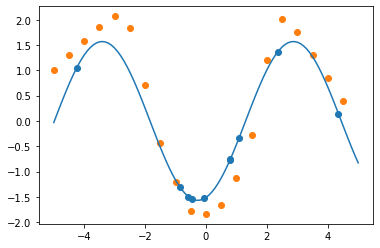

Step 2400: loss = 1.885347592548001


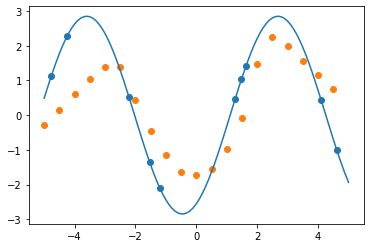

Step 2500: loss = 1.8620879320347297


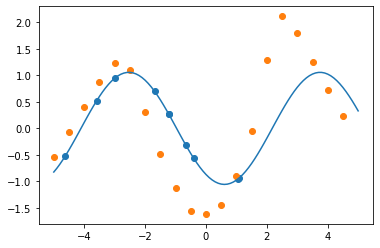

Step 2600: loss = 1.829463472296012


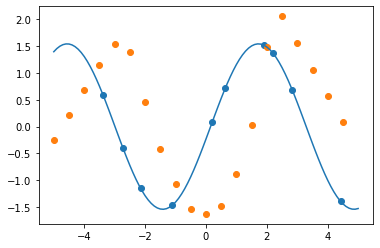

Step 2700: loss = 1.798524756249456


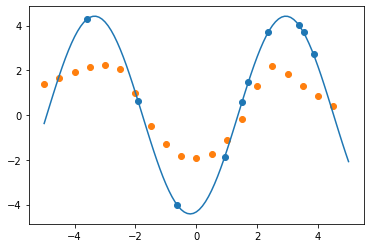

Step 2800: loss = 1.7648315013710154


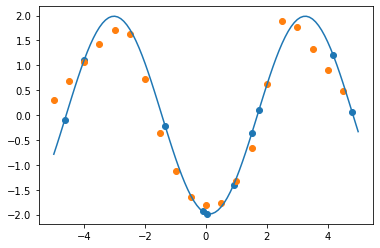

Step 2900: loss = 1.7409004166790938


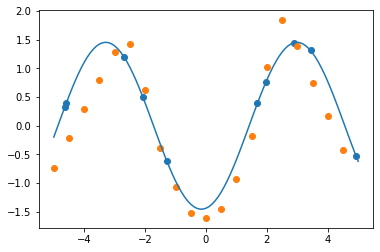

Step 3000: loss = 1.7137156988814803


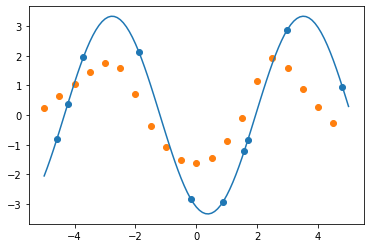

Step 3100: loss = 1.6826443860767017


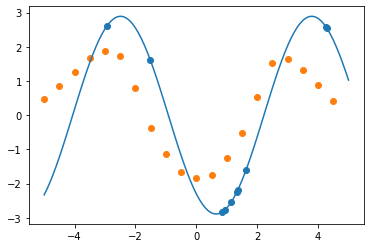

Step 3200: loss = 1.6565217665442826


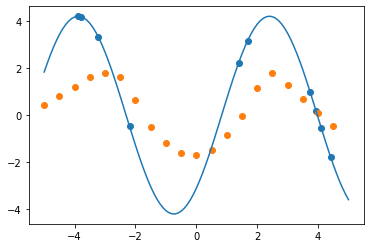

Step 3300: loss = 1.630280726853173


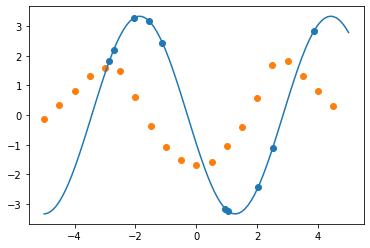

Step 3400: loss = 1.6079492157303545


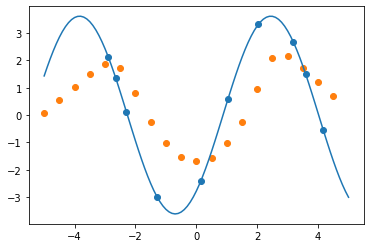

Step 3500: loss = 1.5832501116281472


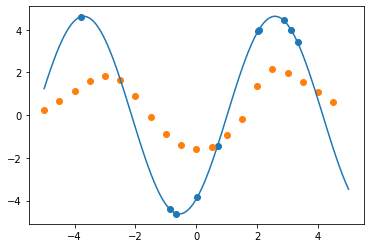

Step 3600: loss = 1.5602184483637225


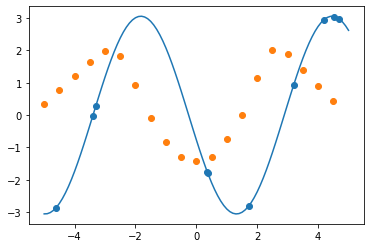

Step 3700: loss = 1.536370122683845


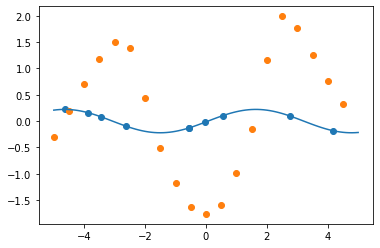

Step 3800: loss = 1.5147966492851872


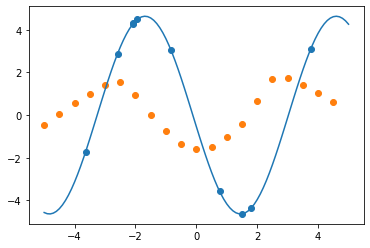

Step 3900: loss = 1.49583086213635


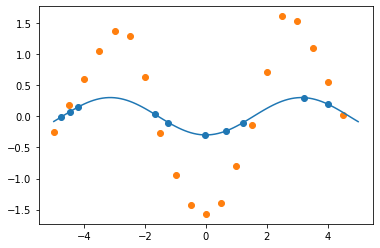

Step 4000: loss = 1.4766203866400667


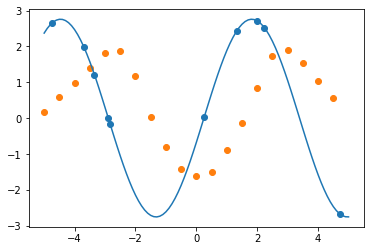

Step 4100: loss = 1.456972147249583


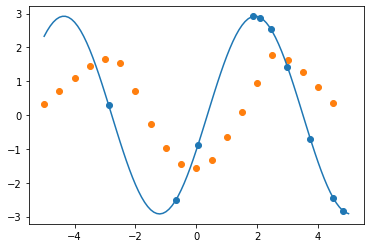

Step 4200: loss = 1.4389935576960353


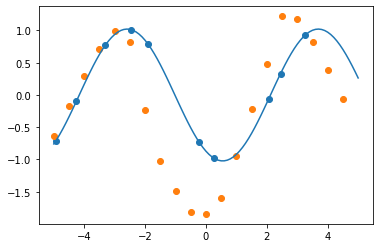

Step 4300: loss = 1.4230059777453634


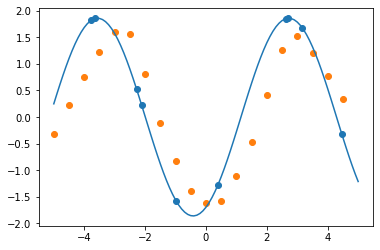

Step 4400: loss = 1.4037308498584369


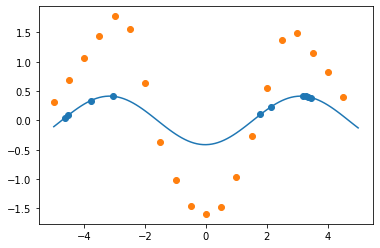

Step 4500: loss = 1.3860743171978989


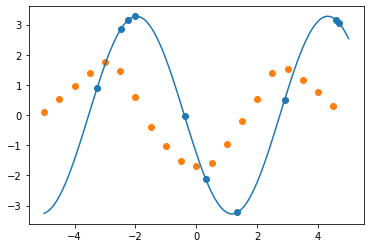

Step 4600: loss = 1.369715325038868


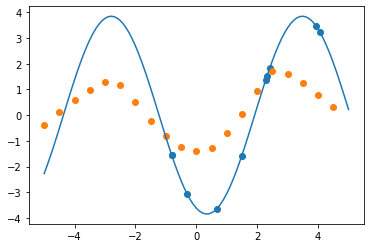

Step 4700: loss = 1.3530378825616007


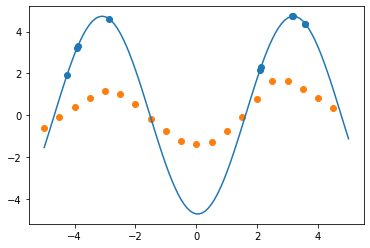

Step 4800: loss = 1.3375043266538904


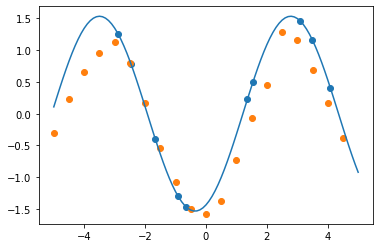

Step 4900: loss = 1.3232668740075644


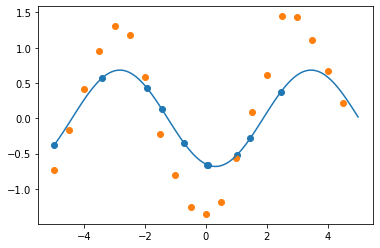

Step 5000: loss = 1.3089071913709502


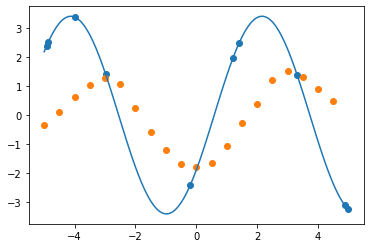

Step 5100: loss = 1.294944479654613


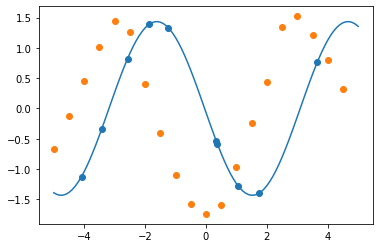

Step 5200: loss = 1.2804301814748995


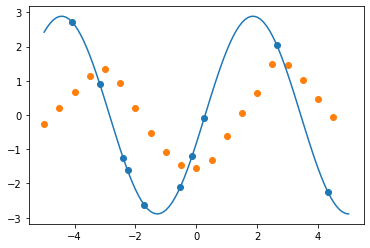

Step 5300: loss = 1.2673135753775358


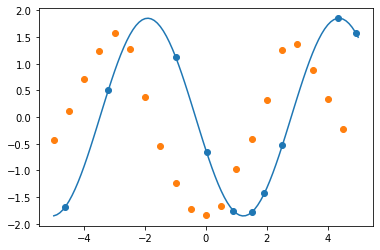

Step 5400: loss = 1.2541859707353775


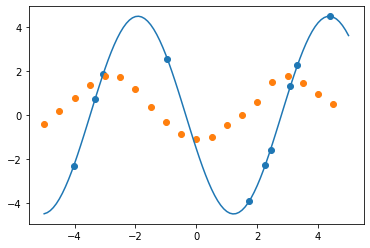

Step 5500: loss = 1.2429098994583252


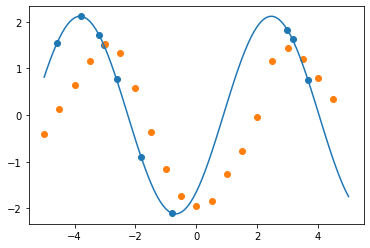

Step 5600: loss = 1.2301497622468935


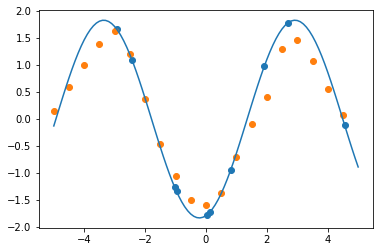

Step 5700: loss = 1.2191168237379841


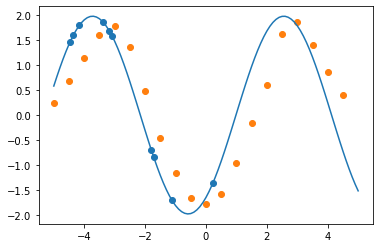

Step 5800: loss = 1.2075809846559085


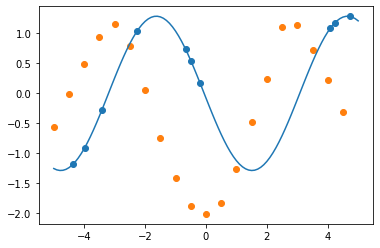

Step 5900: loss = 1.1956932681801886


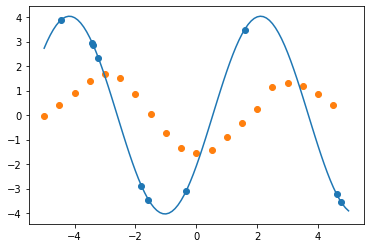

Step 6000: loss = 1.184212697182972


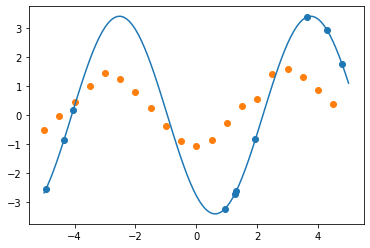

Step 6100: loss = 1.1741925724320976


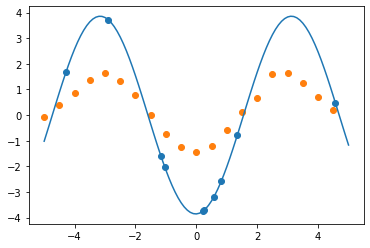

Step 6200: loss = 1.1640225430452429


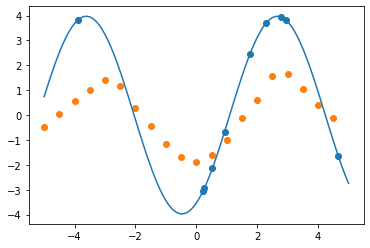

Step 6300: loss = 1.1534179097773234


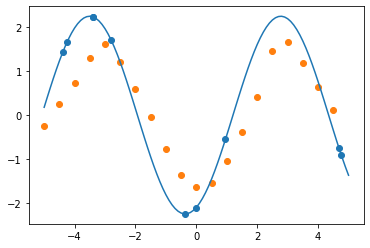

Step 6400: loss = 1.144612468401013


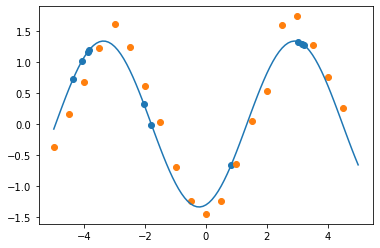

Step 6500: loss = 1.1342603023411413


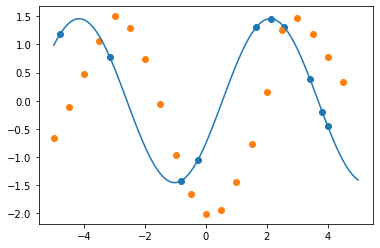

Step 6600: loss = 1.125880718439321


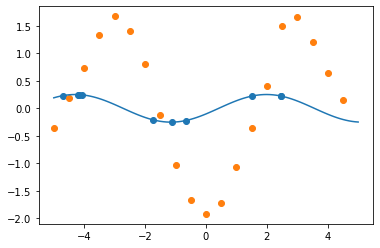

Step 6700: loss = 1.1166434461062307


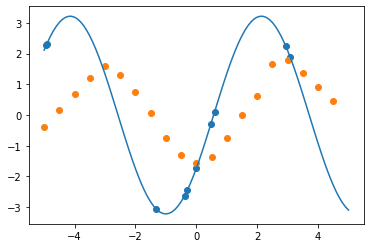

Step 6800: loss = 1.1069389592378163


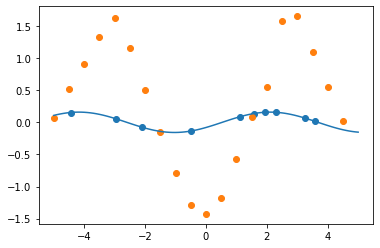

Step 6900: loss = 1.0966839732719624


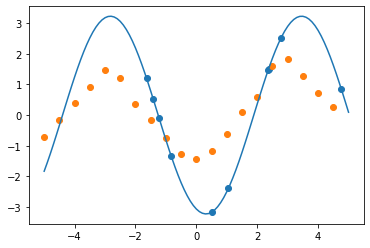

Step 7000: loss = 1.0880369112437915


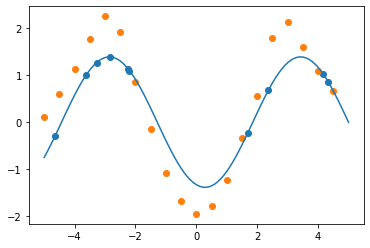

Step 7100: loss = 1.080959413051909


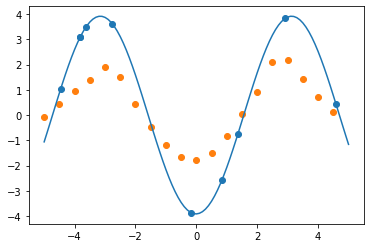

Step 7200: loss = 1.0724716230842286


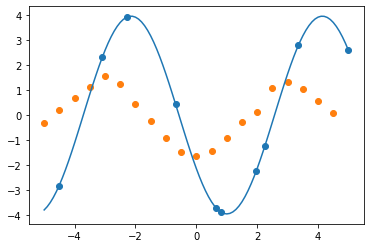

Step 7300: loss = 1.0643793670897657


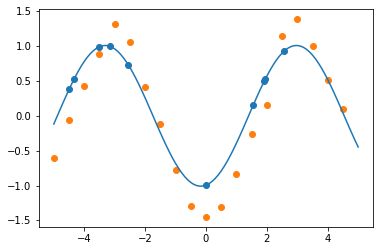

Step 7400: loss = 1.0568629406041934


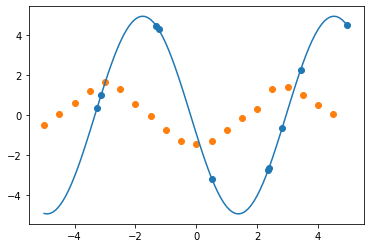

Step 7500: loss = 1.049975952041468


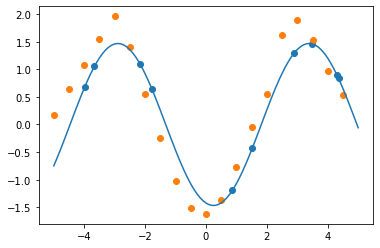

Step 7600: loss = 1.041591700262091


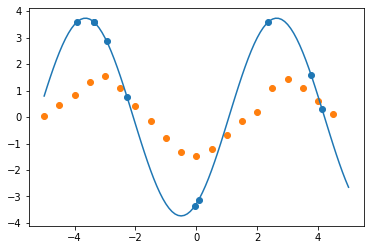

Step 7700: loss = 1.033784994519004


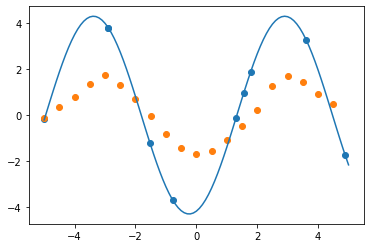

Step 7800: loss = 1.0267037654073794


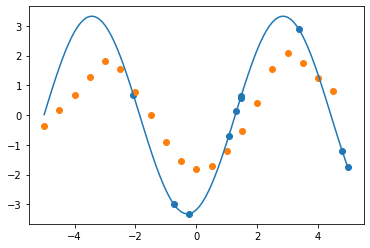

Step 7900: loss = 1.0195262737703161


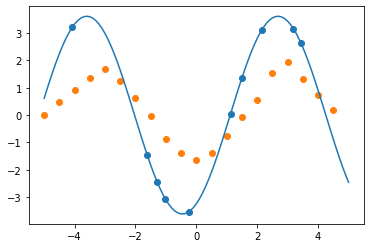

Step 8000: loss = 1.012230183787316


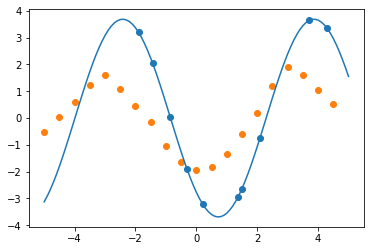

Step 8100: loss = 1.005323654352726


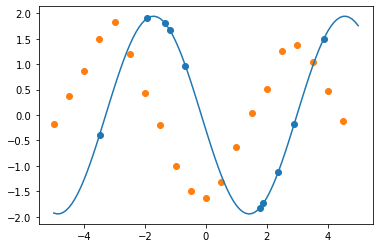

Step 8200: loss = 0.9998707781078214


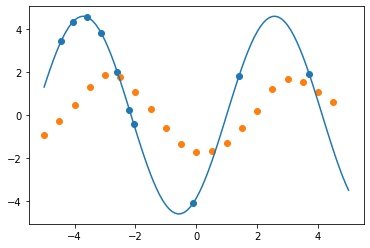

Step 8300: loss = 0.9932769372468657


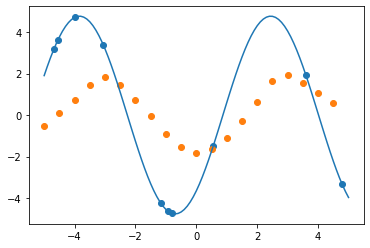

Step 8400: loss = 0.9861393495099752


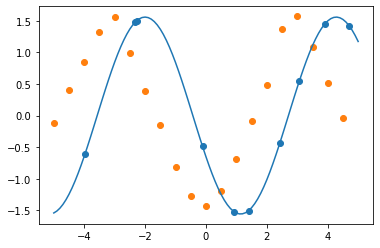

Step 8500: loss = 0.979264101355292


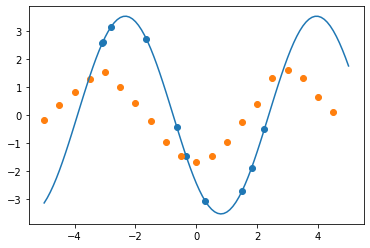

Step 8600: loss = 0.9730114335179397


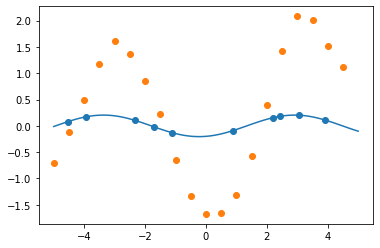

Step 8700: loss = 0.9672828271404317


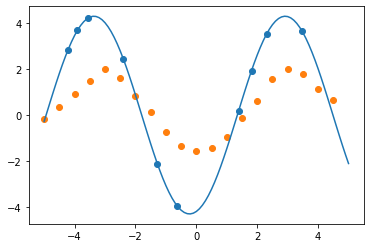

Step 8800: loss = 0.9608800723396616


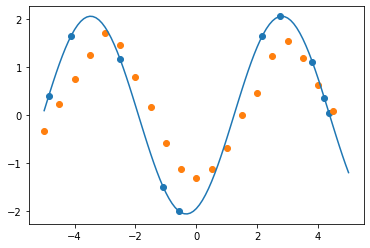

Step 8900: loss = 0.9554563370541848


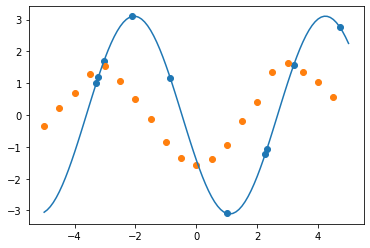

Step 9000: loss = 0.9499858185645925


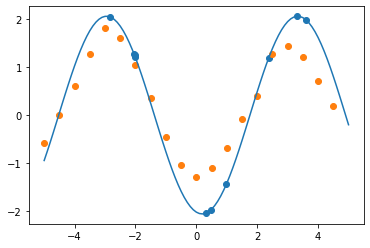

Step 9100: loss = 0.9435414137278525


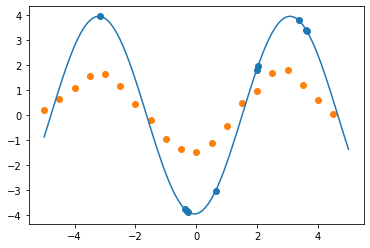

Step 9200: loss = 0.9386096431203468


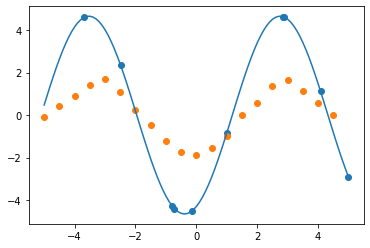

Step 9300: loss = 0.9329006806208331


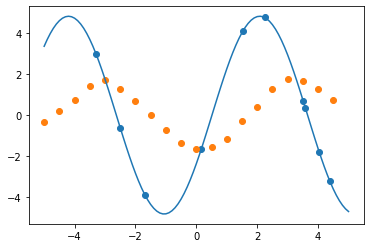

Step 9400: loss = 0.9286929008231305


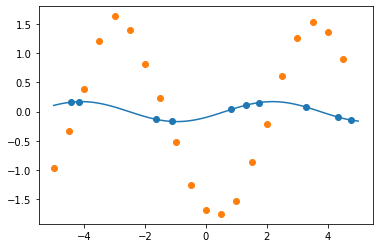

Step 9500: loss = 0.9241781943289606


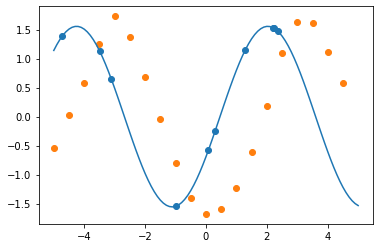

Step 9600: loss = 0.9192234674802663


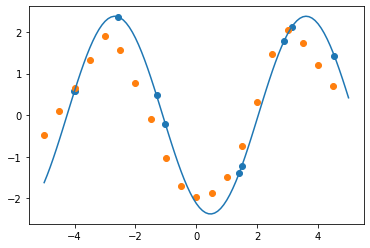

Step 9700: loss = 0.9141289012570635


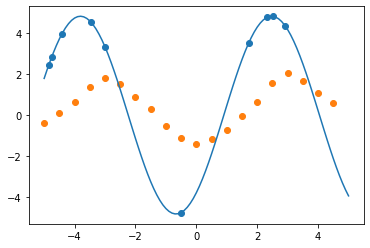

Step 9800: loss = 0.9090774170711019


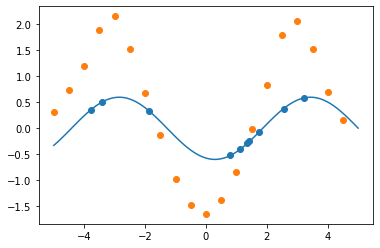

Step 9900: loss = 0.903754386379978


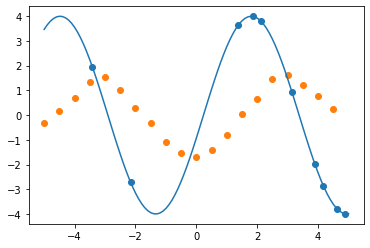

In [10]:
# CREATE THE MODEL maml AND TRAIN IT
maml = 


### Test and comparison of the models


We've tested ours models by plotting intermediate results during the training. Now we can test them with new $SinusoidGenerator$ data. The function test_model is able to test both neural_net and maml. Like in the article, we wish to get the result after training a new task (the testing data) with 0, 1 and 10 gradient descent updates. 

In [11]:
def test_model(model, name, sinusoid_generator=None, num_steps=(0, 1, 10), lr=0.01):
        
    # DEFINE  x_test, y_test as a dataset of 101 points with x in [-5,5] and y = f(x), f being the test function data
    x_test = 
    x_test, y_test = 
    tensor_x_test, tensor_y_test = tf.convert_to_tensor((x_test, y_test))
    
    #DEFINE A DATASET OF 10 random points x, f(x) with f the test function data
    x, y = 

    copied_model = copy_model(model, x)


    optimizer = keras.optimizers.Adam(learning_rate=lr)
    
    fit_res = []
    
    if 0 in num_steps:
        y_pred = model.forward(tensor_x_test)
        loss = loss_function(tensor_y_test, y_pred)
        fit_res.append((0, y_pred, loss))
        
    for step in range(1, np.max(num_steps) + 1):
        train_sample(x, y, model, optimizer)

        #DEFINE y_pred AND loss
        y_pred = 
        loss = 

        if step in num_steps:
            fit_res.append((step, y_pred,loss))   

    plt.plot(x, y, '^', label = 'Training points')

    x_linspace = np.linspace(-5,5,101)
    plt.plot(x_linspace, sinusoid_generator.f(x_linspace), label = 'True function')

    for n, res, loss in fit_res:
        plt.plot(x_test, res[:, 0], '--', label = 'After ' + str(n) + ' steps')
    plt.legend(loc='lower right')
    plt.title(name)

    plt.show()

    return fit_res
    


We can now run the test function for our two models. We want to display as well the loss during the training of a new task. The result shows clearly the fastness of learning for MAML compared to the classic neural network, even with only one training step. 

In [12]:
def compare_maml_and_neural_net(maml, neural_net, sinusoid_generator, num_steps=list(range(10))):

    fit_maml = test_model(maml, 'MAML', sinusoid_generator)
    fit_neural_net = test_model(neural_net, 'Neural network', sinusoid_generator)
    
    fit_res = {'MAML': fit_maml, 'Neural Net': fit_neural_net}
    
    for fit, label in [(fit_maml, 'MAML'), (fit_neural_net, 'Neural network')]:
        n_iter = []
        loss_iter = []
        for n, _, loss in fit:
            n_iter.append(n)
            loss_iter.append(loss)
        plt.plot(n_iter, loss_iter, marker='o', linestyle='--', label = label)

        plt.xticks(num_steps)
    plt.legend(loc='lower right')
    plt.title("Comparison of loss functions")
    plt.show()

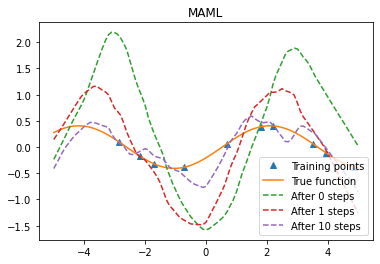

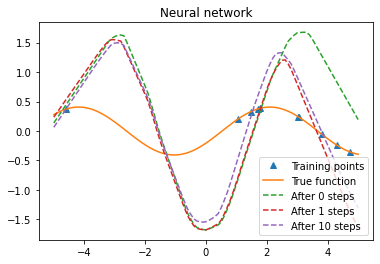

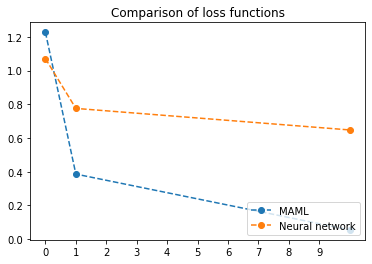

In [13]:
    sine_wave = SinusoidGenerator()
    compare_maml_and_neural_net(maml, neural_net, sine_wave)